# 线性回归的两种代码实现
## 线性回归的从零开始
从零开始实现整个方法，包括数据流水线、模型、损失函数和小批量uiji梯度下降优化器。

In [17]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

### 制造相关数据集
对于下面的问题，我们没有现成的数据集，为了复现这个线性回归过程。这里，我们根据下面的公式，通过添加噪声的方式制造一个人工数据集。  
根据带有噪声的线性模型构造一个人造数据集。 我们使用线性模型参数 $\mathbf{w} = [2, -3.4]^\top$、$b = 4.2$和噪声项$\epsilon$生成数据集及其标签：  
$\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon$  

In [18]:
def synthetic_data(w, b, num_examples):
    """生成y=Xw+b+噪声。"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

`features` 中的每一行都包含一个二维数据样本，`labels` 中的每一行都包含一维标签值（一个标量）

In [19]:
print('features:', features[0], '\nlabel:', labels[0])

features: tensor([-0.5445, -0.8111]) 
label: tensor([5.8573])


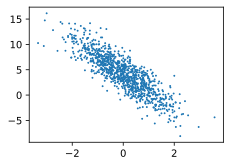

In [20]:
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(),
                labels.detach().numpy(), 1)

### 定义数据流水线
定义一个`data_iter` 函数， 该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为`batch_size`的小批量

In [21]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i:min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.2313, -0.7203],
        [ 0.7618,  0.0811],
        [ 0.2380,  1.0708],
        [ 1.4330,  0.9558],
        [ 0.5641,  1.8048],
        [ 0.7526,  0.7606],
        [-0.7969, -1.1828],
        [ 0.9284,  0.0137],
        [-0.4900,  0.9417],
        [ 0.4169,  1.0208]]) 
 tensor([[ 7.1206],
        [ 5.4659],
        [ 1.0475],
        [ 3.8215],
        [-0.8126],
        [ 3.1167],
        [ 6.6450],
        [ 6.0056],
        [ 0.0188],
        [ 1.5394]])


### 定义初始化模型
先手动的初始化权重矩阵和偏置矩阵，我们不能让权重矩阵和偏置矩阵为全1或全0，最好是随机初始化。

In [22]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

### 定义模型
而后就将线性模型的公式用代码表达出来，这个函数就是模型。

In [23]:
def linreg(X, w, b):
    """线性回归模型"""
    return torch.matmul(X, w) + b

### 定义损失函数
有了模型后，我们需要去衡量我们根据真实的x和y生成的数据集拟合的模型与真实的线性关系间的接近程度。损失函数必然少不了。

In [24]:
def squared_loss(y_hat, y):
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape))**2 / 2

### 定义优化算法

In [25]:
def sgd(params, lr, batch_size):
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

### 训练

In [26]:
lr = 0.005
num_epochs = 10
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        # X和y的小批量损失
        l = loss(net(X, w, b), y)
        # l.shape=[batch_size, 1],不是标量。l中的所有元素被加到一列
        # 并一次计算关于[w, b]的梯度
        l.sum().backward()
        # 使用参数的梯度更新参数
        sgd([w, b], lr, batch_size)
    
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 6.073885
epoch 2, loss 2.288068
epoch 3, loss 0.863631
epoch 4, loss 0.326663
epoch 5, loss 0.123835
epoch 6, loss 0.047048
epoch 7, loss 0.017929
epoch 8, loss 0.006870
epoch 9, loss 0.002654
epoch 10, loss 0.001047


比较真实参数和通过训练学到的参数来评估训练的成功程度

In [27]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([ 0.0247, -0.0272], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0276], grad_fn=<RsubBackward1>)


## 线性回归的pytorch实现
### 制作数据流水线
通过使用深度学习框架来简洁的实现线性回归模型，生成数据集。

In [28]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

true_w = torch.tensor([2.0, -3, 4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

调用框架中的现有API来读取数据

In [29]:
def load_array(data_arrays, batch_size, is_train=True):
    """构造一个Pytorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter1 = load_array((features, labels), batch_size)
next(iter(data_iter1))

[tensor([[-0.2759,  0.7228,  1.3143],
         [ 0.0997,  0.5616,  1.0113],
         [-1.5220, -0.2882,  0.5226],
         [-0.7428,  0.1943, -0.2640],
         [ 0.0946,  0.9886, -2.1461],
         [-0.5833,  1.0403,  0.2512],
         [ 0.6731, -2.2752, -0.2285],
         [ 0.7517, -2.0146, -1.5468],
         [ 0.6776, -2.3522, -1.6407],
         [-0.6284, -1.9441, -1.0560]]),
 tensor([[ 6.7192],
         [ 6.7454],
         [ 4.1252],
         [ 1.0805],
         [-7.1712],
         [ 0.9297],
         [11.4686],
         [ 5.5475],
         [ 6.0476],
         [ 4.5381]])]

### 定义模型
使用框架的预定义好的层

In [30]:
# nn是神经网络的缩写
from torch import nn
net1 = nn.Sequential(nn.Linear(3, 1))

初始化模型参数

In [31]:
net1[0].weight.data.normal_(0, 0.01)
net1[0].bias.data.fill_(0)

tensor([0.])

### 定义损失函数
计算均方误差使用的是MSELoss类，也称为平方L2范数

In [32]:
loss1 = nn.MSELoss()

### 定义优化算法
实例化SGD实例

In [33]:
trainer = torch.optim.SGD(net1.parameters(), lr=0.03)

### 训练
训练过程

In [34]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter1:
        l = loss1(net1(X), y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss1(net1(features), labels)
    print(f'epoch {epoch+1}, loss {l:f}')

epoch 1, loss 0.000571
epoch 2, loss 0.000096
epoch 3, loss 0.000096
